# 因果ダイアグラム

因果関係のグラフィカルモデルとPearl流の因果推論のフレームワークについて。

## 構造的因果モデル

構造的因果モデル（SCM：Structural Causal Model）：変数間の因果関係をグラフで記述するモデル

例えば教育年数$X$と職務経験年数$Z$が給料$Y$に与える影響が

$$
Y = \beta X + \gamma Z
$$

というふうになっていたとする。

グラフィカルモデルは以下のようになる

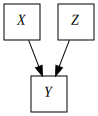

In [1]:
import graphviz

graphviz.Source("""
digraph g {
    graph [rankdir = TB];
    node [shape = square];
        X [label=<<I>X</I>>]
        Y [label=<<I>Y</I>>]
        Z [label=<<I>Z</I>>]
    edge [];
        {X, Z} -> Y
}
""")

## 介入・`do`演算子

条件付確率のような条件付けは、介入とは異なる。

介入はある変数を実際にその値に設定した場合を見ている。一方、条件付けはその条件を満たすものに焦点を絞って見ているに過ぎず、変数の値を変えているわけではない。

$P(Y=y|X=x)$は$X=x$であるという条件のもとで$Y=y$となる確率のこと。

$P(Y=y|do(X=x))$は介入により$X=x$としたとき$Y=y$となる確率のこと。

### 平均因果効果

ある処置$X$を行うことを$do(X=1)$、処置を行わないことを$do(X=0)$とすると、**平均因果効果**（ACE: average causal effect）は

$$
P(Y=1|do(X=1)) - P(Y=1|do(X=0))
$$

と表される。

## 調整

グラフ $G$ において $X$ の親を $PA$ とすると、 $X$ が $Y$ に及ぼす因果効果は

$$
P(Y=y \mid do(X=x))=\sum_z P(Y=y \mid X=x, PA=z) P(PA=z)
$$

で与えられる。ここで$z$は$PA$に含まれる変数がとりうるすべての組み合わせである。


### 逆確率重み付け法

なお、それぞれの項に$P(X=x\mid PA=z)$を掛けて割ることにより、

$$
\begin{align}
P(Y=y \mid do(X=x))
&= \sum_z P(Y=y \mid X=x, PA=z) P(PA=z) \frac{P(X=x\mid PA=z)}{P(X=x\mid PA=z)}\\
&= \sum_z \frac{ P(Y=y \mid X=x, PA=z)  P(X=x\mid PA=z)  P(PA=z)}{P(X=x\mid PA=z)}\\
&= \sum_z \frac{ P(Y=y, X=x, PA=z) }{P(X=x\mid PA=z)}\\
\end{align}
$$

を得る。

$P(X=x\mid PA=z)$は**傾向スコア**（propensity score）と呼ばれる。

介入前における$(X, Y, PA)$の同時確率を$1 / P(X=x\mid PA=z)$倍しているため、この方法は**逆確率重み付け法**と呼ばれる。
標本を$1 / P(X=x\mid PA=z)$倍して、あたかも介入後の分布から抽出したものであるかのように扱うことによって$P(Y=y \mid do(X=x))$を推定する。


**例**

例えば、$X$と$Y$の共通の親に$Z$があるとする。

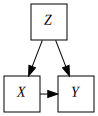

In [17]:
import graphviz

graphviz.Source("""
digraph g {
    graph [rankdir = TB];
    node [shape = square];
        X [label=<<I>X</I>>]
        Y [label=<<I>Y</I>>]
        Z [label=<<I>Z</I>>]
    edge [];
        X -> Y
        {Z} -> {X, Y}
    {rank = same; X, Y}
}
""")

このとき、

$$
P(Y=y \mid do(X=x))=\sum_z P(Y=y \mid X=x, Z=z) P(Z=z)
$$

となる。この式は調整化公式とよばれ、このような処理は「$Z$による調整」「$Z$についてのコントロール」と呼ばれる。

### グラフのタイプ

ノードとエッジのつながりを部分的に見てみると、次の3パターンで構成される

- 連鎖経路（chain, head-to-tail） $X \to Z \to Y$  
- 分岐経路（folk, tail-to-tail） $X \leftarrow Z \rightarrow Y$ 
- 合流経路（collider, head-to-head） $X \rightarrow Z \leftarrow Y$


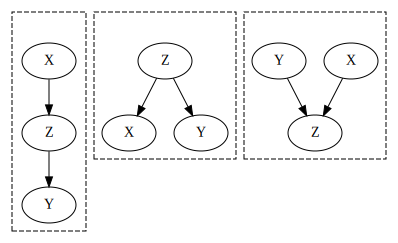

In [10]:
import graphviz

graphviz.Source("""
digraph G {
  rankdir=TB;

  subgraph cluster_chain {
    label="連鎖経路";
    style=dashed;
    X1 [label="X"];
    Z1 [label="Z"];
    Y1 [label="Y"];
    X1 -> Z1 -> Y1;
  }

  subgraph cluster_fork {
    label="分岐経路";
    style=dashed;
    Z2 [label="Z"];
    X2 [label="X"];
    Y2 [label="Y"];
    Z2 -> X2;
    Z2 -> Y2;
  }

  subgraph cluster_collider {
    label="合流経路";
    style=dashed;
    X3 [label="X"];
    Y3 [label="Y"];
    Z3 [label="Z"];
    X3 -> Z3;
    Y3 -> Z3;
  }
}
""")

直接効果を表す$X\to Y$のパスを **直接パス（direct path）** という。

また、直接つながらないが間接的に接続するパスを **バックドアパス（backdoor path）** という。

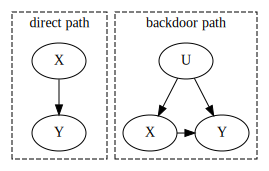

In [25]:
import graphviz

graphviz.Source("""
digraph G {
  rankdir=TB;

  subgraph cluster_chain {
    label="direct path";
    style=dashed;
    X1 [label="X"];
    Y1 [label="Y"];
    X1 -> Y1;
  }

  subgraph cluster_fork {
    label="backdoor path";
    style=dashed;
    U2 [label="U"];
    X2 [label="X"];
    Y2 [label="Y"];
    U2 -> X2;
    U2 -> Y2;
    X2 -> Y2;
    { rank=same; X2; Y2 }
  }

}
""")

## d分離（有向分離）

ノード$X, Y$を別のノード集合$\mathcal{S}$でブロックしているとき、**d分離（d-separation, directional-separation, 有向分離）** されているという

:::{admonition} 定義（d分離）

パス$p$がノードの集合$\mathcal{S}$によってブロックされていることは、以下と同値である。

1. $p$は連鎖経路$X \to Z \to Y$ または分岐経路 $X \leftarrow Z \rightarrow Y$ を含み、中央のノード$Z$が$\mathcal{S}$に含まれる
2. $p$は合流経路$X \rightarrow Z \leftarrow Y$を含み、合流点$Z$やその子孫が集合$\mathcal{S}$に含まれていない

$\mathcal{S}$がノード$X$と$Y$の間のすべてのパスをブロックするとき、$\mathcal{S}$が与えられたもとで$X$と$Y$はd分離されている

$$
(X \perp\!\!\!\perp Y \mid \mathcal{S})_{\text{d-sep}}
$$

すなわち、$\mathcal{S}$が与えられた下で$X$と$Y$は条件付き独立である

:::


## バックドア基準

:::{admonition} 定義（バックドア基準）

非巡回的有向グラフ$G$において変数の順序対$(X, Y)$が与えられたとき、変数の集合$Z$に含まれるいかなるノードも$X$の子孫ではなく、かつ$X$と$Y$の間の道で$X$に向かう矢線を含むようなものすべてを$Z$がブロックするとき、$Z$は$(X,Y)$についてバックドア基準を満たすという。

:::

変数$Z$が$X$と$Y$についてバックドア基準を満たすとき、$X \to Y$の因果効果は

$$
P(Y=y \mid do(X=x))=\sum_z P(Y=y \mid X=x, Z=z) P(Z=z)
$$

で得られる。


一般に、以下の条件を満たすようなノードの集合$Z$について条件付けをおこないたい。

1. XとYの間の擬似パス（バックドアパス）すべてブロックする
2. XからYへの有向道は変更しない
3. 新たな擬似パスは作成しない

## フロントドア基準



:::{admonition} 定義（フロントドア）
変数の集合 $Z$ が以下の条件を満たすとき, $Z$ は順序対 $(X, Y)$ についてフロントドア基準を満たす。
1. $Z$ は $X$ から $Y$への有向道をすべてブロックする
2. $X$ から $Z$ へのバックドアパスは存在しない.
:::

:::{admonition} 定理（フロントドア調整）

$Z$が$(X, Y)$についてのフロントドア基準を満たし、$P(x, z) > 0$であるならば、$X$から$Y$への因果効果は識別可能であり、以下の式で与えられる。

$$
P(y \mid d o(x))=\sum_z P(z \mid x) \sum_{x^{\prime}} P\left(y \mid x^{\prime}, z\right) P\left(x^{\prime}\right)
$$
:::

## 参考文献

- [宮川雅巳. (2005). 因果ダイアグラム・構造方程式モデルによる因果推論. 計算機統計学, 17(1), 45-57.](https://www.jstage.jst.go.jp/article/jscswabun/17/1/17_KJ00002671410/_pdf/-char/ja)
- Pearl（2019）『入門 統計的因果推論』
- [“因果推論駅”の奥の方を探訪しながら考える：われわれの諸研究は内的に/外的にどのような繋がりを持っているのか - Speaker Deck](https://speakerdeck.com/takehikoihayashi/wai-de-nidofalseyounaxi-gariwochi-tuteirufalseka?slide=47)